In [8]:
import numpy as np

In [9]:
Nx = 100
Ny = 100


class Points:
    x_space = np.linspace(0, 1, Nx + 1, endpoint=True)
    y_space = np.linspace(0, 1, Ny + 1, endpoint=True)
    yy, xx = np.meshgrid(y_space, x_space)
    xy = np.stack([xx, yy], axis=2)

    @staticmethod
    def get(i):
        return Points.xy[i[0], i[1]]

    @staticmethod
    def global_idx(i):
        return i[0] * (Nx + 1) + i[1]


#   只是存储点的全局指标，点的全局指标转换成坐标由Points全权负责

class TriangleElement:
    def __init__(self, i, j, k):
        self.i = i
        self.j = j
        self.k = k
    @property
    def p1(self):
        return Points.get(self.i)
    @property
    def p2(self):
        return Points.get(self.j)
    @property
    def p3(self):
        return Points.get(self.k)
    @property
    def area(self):
        # 既然是均匀网格，可以简单地
        # return 1 / Nx / Ny /2
        return (self.p2[0] * self.p3[1] - self.p2[1] * self.p3[0] +
                self.p3[0] * self.p1[1] - self.p3[1] * self.p1[0] +
                self.p1[0] * self.p2[1] - self.p1[1] * self.p2[0]) / 2
    
    def add_local_stiffness(self, global_stiffness: np.array):
        gi = Points.global_idx(self.i)
        gj = Points.global_idx(self.j)
        gk = Points.global_idx(self.k)
        sub_idx = [gi, gj, gk]
        i, j, k = Points.get(self.i), Points.get(self.j), Points.get(self.k)
        local_stiff = np.sum(np.array(
            [[(j - k) ** 2, (i - k) * (k - j), (i - j) * (j - k)],
             [(i - k) * (k - j), (i - k) ** 2, (k - i) * (i - j)],
             [(i - j) * (j - k), (k - i) * (i - j), (i - j) ** 2]]), axis=2) / self.area / 4
        global_stiffness[np.ix_(sub_idx, sub_idx)] += local_stiff
    
    def add_local_load(self, f: callable, global_load: np.array):
        gi = Points.global_idx(self.i)
        gj = Points.global_idx(self.j)
        gk = Points.global_idx(self.k)
        i, j, k = Points.get(self.i), Points.get(self.j), Points.get(self.k)

        def compose_fun(local_idx):
            if local_idx == 0:
                li, lj, lk = i, j, k
            if local_idx == 1:
                lk, li, lj = i, j, k
            if local_idx == 2:
                lj, lk, li = i, j, k

            def _fun(x, y):
                _r = (x * lj[1] - lj[0] * y + lj[0] * lk[1] + lk[0] * y - x * lk[1] - lk[0] * lj[1]) / 2 / self.area
                return _r * f(x, y)

            return _fun

        global_load[gi] += self.quadrature(compose_fun(0))
        global_load[gj] += self.quadrature(compose_fun(1))
        global_load[gk] += self.quadrature(compose_fun(2))
        return self.quadrature(compose_fun(0)), self.quadrature(compose_fun(1)), self.quadrature(compose_fun(2))
    def quadrature(self, q: callable):
        # return f((self.p1[0] + self.p2[0] + self.p3[0]) / 3, (self.p1[1] + self.p2[1] + self.p3[1]) / 3) * self.area
        return (q((self.p1[0] + self.p2[0]) / 2, (self.p1[1] + self.p2[1]) / 2) +
                q((self.p2[0] + self.p3[0]) / 2, (self.p2[1] + self.p3[1]) / 2) +
                q((self.p3[0] + self.p1[0]) / 2, (self.p3[1] + self.p1[1]) / 2)) / 3 * self.area

    def add_local_stiffness2(self, global_stiffness: np.array): #对u这一项的刚度进行计算
        gi = Points.global_idx(self.i)
        gj = Points.global_idx(self.j)
        gk = Points.global_idx(self.k)
        sub_idx = [gi, gj, gk]
        i, j, k = Points.get(self.i), Points.get(self.j), Points.get(self.k)

        def compose_fun2(local_idx1,local_idx2):
            if local_idx1 == 0:
                li, lj, lk = i, j, k
            if local_idx1 == 1:
                lk, li, lj = i, j, k
            if local_idx1 == 2:
                lj, lk, li = i, j, k

            if local_idx2 == 0:
                mi, mj, mk = i, j, k
            if local_idx2 == 1:
                mk, mi, mj = i, j, k
            if local_idx2 == 2:
                mj, mk, mi = i, j, k

            def _fun2(x, y):
                _r2= ((lj[1]-lk[1])*(mj[1]-mk[1])*x*x + (lj[1]-lk[1])*(mk[0]-mj[0])*x*y + (lj[1]-lk[1])*(mj[0]*mk[1]-mk[0]*mj[1])* x +
                      (lk[0]-lj[0])*(mj[1]-mk[1])*y*x + (lk[0]-lj[0])*(mk[0]-mj[0])*y*y + (lk[0]-lj[0])*(mj[0]*mk[1]-mk[0]*mj[1])* y +
                      (lj[0]*lk[1]-lk[0]*lj[1])*(mj[1]-mk[1])*x + (lj[0]*lk[1]-lk[0]*lj[1])*(mk[0]-mj[0])*y + (lj[0]*lk[1]-lk[0]*lj[1])*(mj[0]*mk[1]-mk[0]*mj[1]) )/ 4 / self.area / self.area
                return _r2 

            return _fun2
        
        for _i in range(0,3):
            for _j in range(0,3):
                
                local_stiff2 =  np.zeros((3, 3))
                
                local_stiff2[np.ix_([_i], [_j])] += self.quadrature(compose_fun2(_i,_j))

        
        def quadrature(self, q: callable):
        # return f((self.p1[0] + self.p2[0] + self.p3[0]) / 3, (self.p1[1] + self.p2[1] + self.p3[1]) / 3) * self.area
            return (q((self.p1[0] + self.p2[0]) / 2, (self.p1[1] + self.p2[1]) / 2) +
                q((self.p2[0] + self.p3[0]) / 2, (self.p2[1] + self.p3[1]) / 2) +
                q((self.p3[0] + self.p1[0]) / 2, (self.p3[1] + self.p1[1]) / 2)) / 3 * self.area

        

        global_stiffness[np.ix_(sub_idx, sub_idx)] += local_stiff2
        
            

In [10]:
import matplotlib.pyplot as plt
import math
pai=math.pi

In [11]:
def q(xx, yy):
    return 2 *(pai**2+1)*math.sin(pai*xx)*math.sin(pai*yy)

element_list = []
for ix in range(Nx):
    for iy in range(Ny):
        element_list.append(TriangleElement((ix, iy), (ix + 1, iy), (ix, iy + 1)))
        element_list.append(TriangleElement((ix, iy + 1), (ix + 1, iy), (ix + 1, iy + 1)))
global_stiffness = np.zeros(((Nx + 1) * (Ny + 1), (Nx + 1) * (Ny + 1)))

[[ 1.  -0.5  0.  ...  0.   0.   0. ]
 [-0.5  2.  -0.5 ...  0.   0.   0. ]
 [ 0.  -0.5  2.  ...  0.   0.   0. ]
 ...
 [ 0.   0.   0.  ...  2.  -0.5  0. ]
 [ 0.   0.   0.  ... -0.5  2.  -0.5]
 [ 0.   0.   0.  ...  0.  -0.5  1. ]]
[[ 1.         -0.5         0.         ...  0.          0.
   0.        ]
 [-0.5         2.00000833 -0.5        ...  0.          0.
   0.        ]
 [ 0.         -0.5         2.00000833 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  2.00000833 -0.5
   0.        ]
 [ 0.          0.          0.         ... -0.5         2.00000833
  -0.5       ]
 [ 0.          0.          0.         ...  0.         -0.5
   1.00000833]]


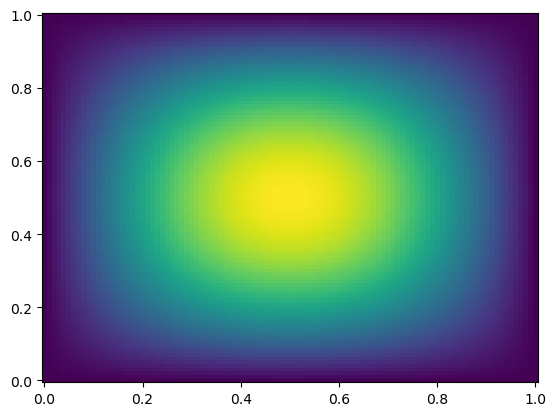

In [12]:

[te.add_local_stiffness(global_stiffness) for te in element_list]
print (global_stiffness)
[te.add_local_stiffness2(global_stiffness) for te in element_list]
print (global_stiffness)
interior_idx = (Nx + 1) * np.arange(1, Nx).reshape(Nx - 1, 1) + np.arange(1, Ny).reshape(1, Ny - 1)
interior_idx = interior_idx.ravel()
global_stiffness = global_stiffness[np.ix_(interior_idx, interior_idx)]
global_load = np.zeros((Nx + 1) * (Ny + 1))
[te.add_local_load(q, global_load) for te in element_list]
global_load = global_load[interior_idx]
res = np.linalg.solve(global_stiffness, global_load)
res = res.reshape(Nx - 1, Ny - 1)
res = np.pad(res, pad_width=1, mode='constant', constant_values=0)
plt.pcolormesh(Points.xx, Points.yy, res)
plt.savefig('D:\\资料\\FEres1.png')
plt.show()


In [138]:
res

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.10239224, 0.19546212, 0.26971651, 0.31771655,
        0.33467525, 0.3188736 , 0.27179942, 0.19797224, 0.10444844,
        0.        ],
       [0.        , 0.19546212, 0.37258995, 0.51366961, 0.60468077,
        0.63659016, 0.60618567, 0.5163549 , 0.37576666, 0.19797224,
        0.        ],
       [0.        , 0.26971651, 0.51366961, 0.70770627, 0.83266078,
        0.87619118, 0.83395389, 0.71000084, 0.5163549 , 0.27179942,
        0.        ],
       [0.        , 0.31771655, 0.60468077, 0.83266078, 0.97924606,
        1.03002451, 0.97997698, 0.83395389, 0.60618567, 0.3188736 ,
        0.        ],
       [0.        , 0.33467525, 0.63659016, 0.87619118, 1.03002451,
        1.08303186, 1.03002451, 0.87619118, 0.63659016, 0.33467525,
        0.        ],
       [0.        , 0.3188736 , 0.60618567, 0.83395389, 0.

In [13]:
x = np.linspace(0,1,Nx+1)
y = np.linspace(0,1,Ny+1)
I = np.zeros((Nx+1,Ny+1))
for ii in range(Nx+1):
    for jj in range(Ny+1):
        I[np.ix_([ii], [jj])] = math.sin(pai*x[ii])*math.sin(pai*y[jj])
I

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 9.86635786e-04, 1.97229788e-03, ...,
        1.97229788e-03, 9.86635786e-04, 3.84670856e-18],
       [0.00000000e+00, 1.97229788e-03, 3.94264934e-03, ...,
        3.94264934e-03, 1.97229788e-03, 7.68962088e-18],
       ...,
       [0.00000000e+00, 1.97229788e-03, 3.94264934e-03, ...,
        3.94264934e-03, 1.97229788e-03, 7.68962088e-18],
       [0.00000000e+00, 9.86635786e-04, 1.97229788e-03, ...,
        1.97229788e-03, 9.86635786e-04, 3.84670856e-18],
       [0.00000000e+00, 3.84670856e-18, 7.68962088e-18, ...,
        7.68962088e-18, 3.84670856e-18, 1.49975978e-32]])

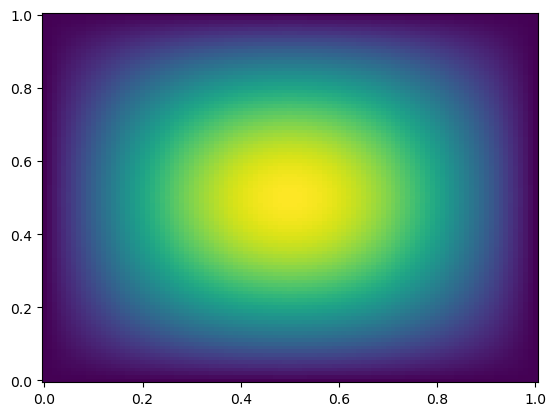

In [14]:
plt.pcolormesh(x, y, I)
plt.savefig('D:\\资料\\Mathres.png')
plt.show()

In [15]:
tol = I - res
tol

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -9.04190489e-05, -1.80837809e-04, ...,
        -1.82102616e-04, -9.11407526e-05,  3.84670856e-18],
       [ 0.00000000e+00, -1.80837809e-04, -3.61620900e-04, ...,
        -3.63901772e-04, -1.82102616e-04,  7.68962088e-18],
       ...,
       [ 0.00000000e+00, -1.82102616e-04, -3.63901772e-04, ...,
        -3.61620900e-04, -1.80837809e-04,  7.68962088e-18],
       [ 0.00000000e+00, -9.11407526e-05, -1.82102616e-04, ...,
        -1.80837809e-04, -9.04190489e-05,  3.84670856e-18],
       [ 0.00000000e+00,  3.84670856e-18,  7.68962088e-18, ...,
         7.68962088e-18,  3.84670856e-18,  1.49975978e-32]])

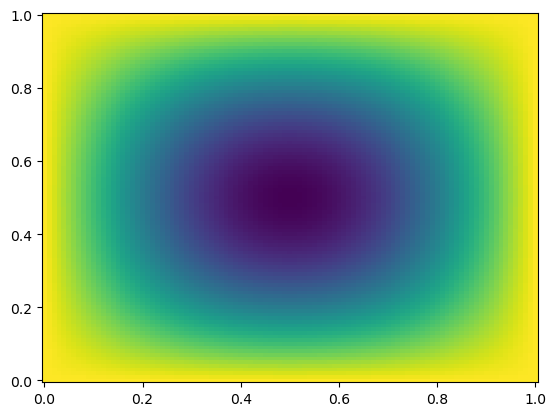

In [16]:
plt.pcolormesh(x, y, tol)
plt.savefig('D:\\资料\\tol.png')
plt.show()

In [143]:
Y = np.linalg.norm(tol,ord=None)
Y

0.4152392313172737